In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import time
import re
import tensorflow as tf
import tensorflow_hub as hub
import pickle
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import string
%matplotlib inline

os.chdir("/Users/alexdessouky/Desktop/MIDS/w266")

#load training data
twitter_train = pd.read_excel('./w266_final_project/StanceDataset/train.xlsx')

#load test data
twitter_test = pd.read_excel('./w266_final_project/StanceDataset/test.xlsx')

In [2]:
twitter_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [3]:
twitter_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


## Code for loading full Elmo outputs from pickle files and prepping labelled data

In [4]:
# ELMO OUTPUTS
with open("./ELMO Outputs v.2/elmo_train.pickle", "rb") as f:
    train_vectors = pickle.load(f)
    
with open("./ELMO Outputs v.2/elmo_test.pickle", "rb") as f:
    test_vectors = pickle.load(f)

In [5]:
#PREP LABELS
stance_labels_train = np.array(twitter_train['Stance'].apply(lambda x: 
                                                                    2 if x == "FAVOR" else 
                                                                    (1 if x == "NONE" else 0)))

stance_labels_test = np.array(twitter_test['Stance'].apply(lambda x: 
                                                                    2 if x == "FAVOR" else 
                                                                    (1 if x == "NONE" else 0)))

In [6]:
#PREP LABELS FOR NN
train_y = np.zeros(shape = (stance_labels_train.shape[0],3))
train_y[stance_labels_train == 0,0] = 1
train_y[stance_labels_train == 1,1] = 1
train_y[stance_labels_train == 2,2] = 1

test_y = np.zeros(shape = (stance_labels_test.shape[0],3))
test_y[stance_labels_test == 0,0] = 1
test_y[stance_labels_test == 1,1] = 1
test_y[stance_labels_test == 2,2] = 1

## Helper function to obtain topic training / dev subsets

In [7]:
def topic_subset(topic_list, layer):
        
    #convert topic list to lower case
    for i in range(0,len(topic_list)):
        topic_list[i] = topic_list[i].lower()
    
    #find boolean series of all rows pertaining to the relevant topics
    matches_train = twitter_train['Target'].apply(lambda x: x.lower() in topic_list)
    matches_test = twitter_test['Target'].apply(lambda x: x.lower() in topic_list)
    
    #subset data and labels
    train_labels = train_y[matches_train,:]
    test_labels = test_y[matches_test,:]
    
    #pull features
    train_data = train_vectors[layer][matches_train,:,:]
    test_data = np.pad(test_vectors[layer], pad_width = ((0,0),(1,1),(0,0)), 
                      mode = 'constant', constant_values = 0)[matches_test,:,:]
    
    #also need to return the test labels in this format for metrics
    true_labels = stance_labels_test[matches_test]
    
    return train_data, train_labels, test_data, test_labels, true_labels

## Helper function for model performances

In [8]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [9]:
def metrics(true_labels, test_probs):
    
    #find predicted labels
    test_predicts = np.argmax(test_probs, axis = 1)
    
    #calculate f1 score
    f1 = f1_score(true_labels, test_predicts, average = 'macro')
    
    print("F1 macro score:", f1)
    
    print(classification_report(y_true = true_labels, 
                                        y_pred = test_predicts,
                                        target_names = ['Against', 'None', 'Favor']))
    
    confuse = confusion_matrix(y_true = true_labels, y_pred = test_predicts)
    
    plt.figure(figsize=(15, 5))
    confusion_plot(confuse, ['Against', 'None', 'Favor'])
    plt.show()

## Define model

In [10]:
def lstm_model(activation_function_lstm = 'tanh', 
                optimizer='adam', 
                kernel_initializer=tf.keras.initializers.he_normal(seed=123), 
                bias_initializer='zeros'):
    
    # Define Input layer(s)
    input_vectors = tf.keras.layers.Input(shape=(32,1024), name="input_numbers")
    
    #define LSTM layter
    lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, 
                                 input_shape = (32,1024),
                                 activation=activation_function_lstm,
                                 recurrent_activation= activation_function_lstm,
                                 kernel_initializer=kernel_initializer,
                                 recurrent_initializer=kernel_initializer,
                                 bias_initializer=bias_initializer,
                                 dropout = 0.5,
                                 name='lstm1'), merge_mode = 'concat')
    #run lstm layer 1
    lstm_output1 = lstm1(input_vectors)
    
    #dense1 = tf.keras.layers.Dense(6,
                                  #activation='tanh',
                                  #kernel_initializer = kernel_initializer,
                                  #bias_initializer = 'zeros')
    
    #dense1_output = dense1(lstm_output1)
    
    #define classification layer (softmax since we have 3 classes)
    classification_layer = tf.keras.layers.Dense(3, activation='softmax', name='classification') # layer definition
    classification_output = classification_layer(lstm_output1)   # layer acting on previous layer's output

    # Build and compile model
    lstm_mod = tf.keras.models.Model(input_vectors, classification_output)
    
    lstm_mod.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['categorical_accuracy'])
    
    return lstm_mod

lstm_mod = lstm_model()
lstm_mod.summary()
    
    

W1105 21:11:31.404305 140736218923904 deprecation.py:506] From /Users/alexdessouky/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1105 21:11:31.408499 140736218923904 deprecation.py:506] From /Users/alexdessouky/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_numbers (InputLayer)   [(None, 32, 1024)]        0         
_________________________________________________________________
bidirectional (Bidirectional (None, 12)                49488     
_________________________________________________________________
classification (Dense)       (None, 3)                 39        
Total params: 49,527
Trainable params: 49,527
Non-trainable params: 0
_________________________________________________________________


# Run LSTM on 'ELMO' outputs

In [11]:
#Atheism

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Atheism'], 'elmo')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 410 samples, validate on 103 samples
Epoch 1/100
410/410 - 2s - loss: 233.6325 - categorical_accuracy: 0.3244 - val_loss: 293.5765 - val_categorical_accuracy: 0.5437
Epoch 2/100
410/410 - 1s - loss: 222.4420 - categorical_accuracy: 0.3537 - val_loss: 253.5803 - val_categorical_accuracy: 0.7379
Epoch 3/100
410/410 - 1s - loss: 199.8143 - categorical_accuracy: 0.4415 - val_loss: 203.0084 - val_categorical_accuracy: 0.7961
Epoch 4/100
410/410 - 1s - loss: 175.3370 - categorical_accuracy: 0.5195 - val_loss: 148.9644 - val_categorical_accuracy: 0.8738
Epoch 5/100
410/410 - 1s - loss: 160.9510 - categorical_accuracy: 0.5073 - val_loss: 122.8043 - val_categorical_accuracy: 0.8738
Epoch 6/100
410/410 - 1s - loss: 153.6276 - categorical_accuracy: 0.5244 - val_loss: 110.2656 - val_categorical_accuracy: 0.8738
Epoch 7/100
410/410 - 1s - loss: 151.2081 - categorical_accuracy: 0.5244 - val_loss: 102.9752 - val_categorical_accuracy: 0.8738
Epoch 8/100
410/410 - 1s - loss: 154.5469 - categor

Epoch 64/100
410/410 - 1s - loss: 103.6355 - categorical_accuracy: 0.6659 - val_loss: 121.0853 - val_categorical_accuracy: 0.7767
Epoch 65/100
410/410 - 1s - loss: 97.2830 - categorical_accuracy: 0.6732 - val_loss: 131.5019 - val_categorical_accuracy: 0.7573
Epoch 66/100
410/410 - 1s - loss: 90.9863 - categorical_accuracy: 0.7049 - val_loss: 138.5325 - val_categorical_accuracy: 0.7573
Epoch 67/100
410/410 - 1s - loss: 96.9479 - categorical_accuracy: 0.7073 - val_loss: 140.3878 - val_categorical_accuracy: 0.7476
Epoch 68/100
410/410 - 1s - loss: 90.8552 - categorical_accuracy: 0.7195 - val_loss: 148.3098 - val_categorical_accuracy: 0.7184
Epoch 69/100
410/410 - 1s - loss: 95.1062 - categorical_accuracy: 0.7195 - val_loss: 157.6946 - val_categorical_accuracy: 0.7573
Epoch 70/100
410/410 - 1s - loss: 92.1734 - categorical_accuracy: 0.7439 - val_loss: 156.2755 - val_categorical_accuracy: 0.7476
Epoch 71/100
410/410 - 1s - loss: 88.1952 - categorical_accuracy: 0.7439 - val_loss: 154.6831 - 

F1 macro score: 0.44720524353208013
              precision    recall  f1-score   support

     Against       0.79      0.64      0.71       160
        None       0.22      0.61      0.33        28
       Favor       0.50      0.22      0.30        32

   micro avg       0.58      0.58      0.58       220
   macro avg       0.51      0.49      0.45       220
weighted avg       0.68      0.58      0.60       220



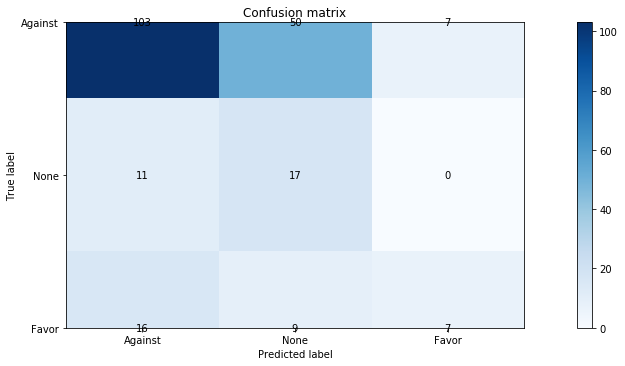

In [12]:
#show metrics
metrics(true_labels, test_probs)

In [13]:
#Hillary Clinton

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton'], 'elmo')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 551 samples, validate on 138 samples
Epoch 1/100
551/551 - 1s - loss: 339.8998 - categorical_accuracy: 0.3702 - val_loss: 190.1535 - val_categorical_accuracy: 0.7174
Epoch 2/100
551/551 - 1s - loss: 270.5512 - categorical_accuracy: 0.4737 - val_loss: 131.1569 - val_categorical_accuracy: 0.7971
Epoch 3/100
551/551 - 1s - loss: 255.3799 - categorical_accuracy: 0.5227 - val_loss: 130.3052 - val_categorical_accuracy: 0.7971
Epoch 4/100
551/551 - 1s - loss: 243.2560 - categorical_accuracy: 0.5064 - val_loss: 147.2006 - val_categorical_accuracy: 0.7826
Epoch 5/100
551/551 - 1s - loss: 232.3863 - categorical_accuracy: 0.5082 - val_loss: 177.7710 - val_categorical_accuracy: 0.7464
Epoch 6/100
551/551 - 1s - loss: 222.9435 - categorical_accuracy: 0.5045 - val_loss: 163.3098 - val_categorical_accuracy: 0.7754
Epoch 7/100
551/551 - 1s - loss: 211.1518 - categorical_accuracy: 0.5191 - val_loss: 151.7842 - val_categorical_accuracy: 0.7754
Epoch 8/100
551/551 - 1s - loss: 210.6534 - categor

Epoch 64/100
551/551 - 1s - loss: 135.8166 - categorical_accuracy: 0.6497 - val_loss: 179.7138 - val_categorical_accuracy: 0.7609
Epoch 65/100
551/551 - 1s - loss: 131.3798 - categorical_accuracy: 0.6860 - val_loss: 179.3590 - val_categorical_accuracy: 0.7609
Epoch 66/100
551/551 - 1s - loss: 125.3159 - categorical_accuracy: 0.6842 - val_loss: 197.4673 - val_categorical_accuracy: 0.7536
Epoch 67/100
551/551 - 1s - loss: 134.3445 - categorical_accuracy: 0.6897 - val_loss: 201.4467 - val_categorical_accuracy: 0.7391
Epoch 68/100
551/551 - 1s - loss: 124.4349 - categorical_accuracy: 0.7060 - val_loss: 183.5415 - val_categorical_accuracy: 0.7464
Epoch 69/100
551/551 - 1s - loss: 127.6874 - categorical_accuracy: 0.6788 - val_loss: 172.7504 - val_categorical_accuracy: 0.7754
Epoch 70/100
551/551 - 1s - loss: 127.1128 - categorical_accuracy: 0.6878 - val_loss: 178.9643 - val_categorical_accuracy: 0.7681
Epoch 71/100
551/551 - 1s - loss: 121.5041 - categorical_accuracy: 0.7078 - val_loss: 180.

/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alexdessouky/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 macro score: 0.2614344503233392
              precision    recall  f1-score   support

     Against       0.55      0.74      0.63       172
        None       0.18      0.14      0.16        78
       Favor       0.00      0.00      0.00        45

   micro avg       0.47      0.47      0.47       295
   macro avg       0.24      0.29      0.26       295
weighted avg       0.36      0.47      0.41       295



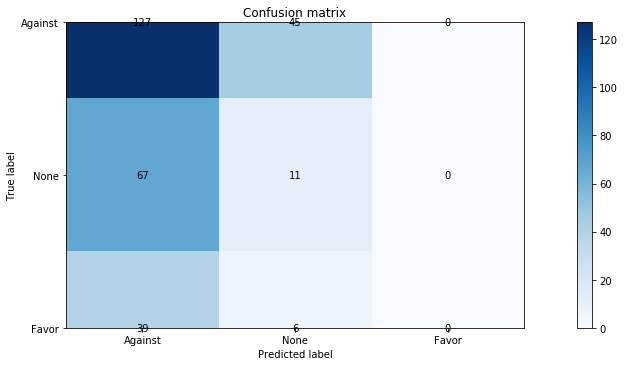

In [14]:
#show metrics
metrics(true_labels, test_probs)

In [15]:
#Abortion

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Legalization of Abortion'], 'elmo')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 522 samples, validate on 131 samples
Epoch 1/100
522/522 - 1s - loss: 280.7875 - categorical_accuracy: 0.4425 - val_loss: 213.7104 - val_categorical_accuracy: 0.6412
Epoch 2/100
522/522 - 1s - loss: 251.6252 - categorical_accuracy: 0.5172 - val_loss: 186.4091 - val_categorical_accuracy: 0.6641
Epoch 3/100
522/522 - 1s - loss: 225.7238 - categorical_accuracy: 0.5211 - val_loss: 182.4918 - val_categorical_accuracy: 0.6718
Epoch 4/100
522/522 - 1s - loss: 221.8609 - categorical_accuracy: 0.5421 - val_loss: 196.1658 - val_categorical_accuracy: 0.6412
Epoch 5/100
522/522 - 1s - loss: 225.6429 - categorical_accuracy: 0.5153 - val_loss: 206.4807 - val_categorical_accuracy: 0.6183
Epoch 6/100
522/522 - 1s - loss: 206.3058 - categorical_accuracy: 0.5479 - val_loss: 211.5228 - val_categorical_accuracy: 0.6260
Epoch 7/100
522/522 - 1s - loss: 203.8830 - categorical_accuracy: 0.5632 - val_loss: 211.2948 - val_categorical_accuracy: 0.6565
Epoch 8/100
522/522 - 1s - loss: 197.6692 - categor

Epoch 64/100
522/522 - 1s - loss: 120.3047 - categorical_accuracy: 0.7107 - val_loss: 231.4261 - val_categorical_accuracy: 0.6260
Epoch 65/100
522/522 - 1s - loss: 124.0782 - categorical_accuracy: 0.7050 - val_loss: 226.4340 - val_categorical_accuracy: 0.6412
Epoch 66/100
522/522 - 1s - loss: 121.8070 - categorical_accuracy: 0.7107 - val_loss: 228.8848 - val_categorical_accuracy: 0.6260
Epoch 67/100
522/522 - 1s - loss: 114.8434 - categorical_accuracy: 0.7222 - val_loss: 227.8821 - val_categorical_accuracy: 0.6260
Epoch 68/100
522/522 - 1s - loss: 115.4092 - categorical_accuracy: 0.7222 - val_loss: 223.4122 - val_categorical_accuracy: 0.6412
Epoch 69/100
522/522 - 1s - loss: 109.8942 - categorical_accuracy: 0.7337 - val_loss: 225.8468 - val_categorical_accuracy: 0.6260
Epoch 70/100
522/522 - 1s - loss: 112.3783 - categorical_accuracy: 0.7337 - val_loss: 232.9893 - val_categorical_accuracy: 0.6336
Epoch 71/100
522/522 - 1s - loss: 115.9931 - categorical_accuracy: 0.7261 - val_loss: 231.

F1 macro score: 0.34437817778741664
              precision    recall  f1-score   support

     Against       0.67      0.88      0.76       189
        None       0.26      0.16      0.19        45
       Favor       0.29      0.04      0.08        46

   micro avg       0.62      0.62      0.62       280
   macro avg       0.41      0.36      0.34       280
weighted avg       0.54      0.62      0.56       280



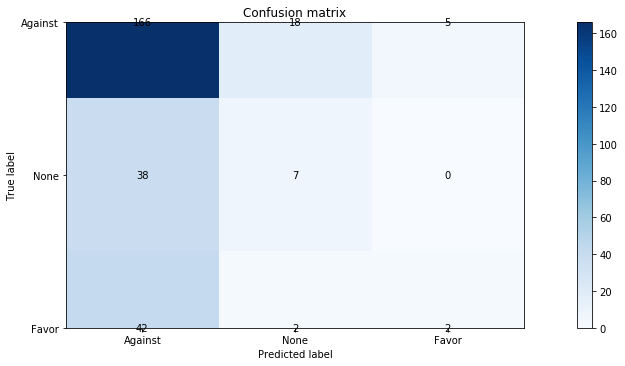

In [16]:
#show metrics
metrics(true_labels, test_probs)

In [17]:
#Climate

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Climate Change is a Real Concern'], 'elmo')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 316 samples, validate on 79 samples
Epoch 1/100
316/316 - 0s - loss: 393.7869 - categorical_accuracy: 0.2405 - val_loss: 298.1110 - val_categorical_accuracy: 0.3671
Epoch 2/100
316/316 - 0s - loss: 318.5270 - categorical_accuracy: 0.3259 - val_loss: 246.6625 - val_categorical_accuracy: 0.3924
Epoch 3/100
316/316 - 0s - loss: 282.8898 - categorical_accuracy: 0.3165 - val_loss: 219.0412 - val_categorical_accuracy: 0.4051
Epoch 4/100
316/316 - 0s - loss: 228.8434 - categorical_accuracy: 0.3671 - val_loss: 196.8874 - val_categorical_accuracy: 0.4557
Epoch 5/100
316/316 - 1s - loss: 211.7925 - categorical_accuracy: 0.4399 - val_loss: 179.4932 - val_categorical_accuracy: 0.4810
Epoch 6/100
316/316 - 0s - loss: 183.8273 - categorical_accuracy: 0.4905 - val_loss: 168.4182 - val_categorical_accuracy: 0.4810
Epoch 7/100
316/316 - 0s - loss: 172.0150 - categorical_accuracy: 0.4842 - val_loss: 160.9830 - val_categorical_accuracy: 0.4810
Epoch 8/100
316/316 - 0s - loss: 161.2597 - categori

Epoch 64/100
316/316 - 0s - loss: 77.3401 - categorical_accuracy: 0.7975 - val_loss: 117.5670 - val_categorical_accuracy: 0.5696
Epoch 65/100
316/316 - 0s - loss: 76.9009 - categorical_accuracy: 0.7848 - val_loss: 121.5854 - val_categorical_accuracy: 0.5949
Epoch 66/100
316/316 - 0s - loss: 75.5418 - categorical_accuracy: 0.8133 - val_loss: 120.6780 - val_categorical_accuracy: 0.6203
Epoch 67/100
316/316 - 0s - loss: 77.6138 - categorical_accuracy: 0.7816 - val_loss: 119.3581 - val_categorical_accuracy: 0.5949
Epoch 68/100
316/316 - 0s - loss: 82.7397 - categorical_accuracy: 0.7690 - val_loss: 116.3245 - val_categorical_accuracy: 0.5949
Epoch 69/100
316/316 - 0s - loss: 72.9463 - categorical_accuracy: 0.8101 - val_loss: 119.6166 - val_categorical_accuracy: 0.5823
Epoch 70/100
316/316 - 1s - loss: 80.5165 - categorical_accuracy: 0.7658 - val_loss: 118.1706 - val_categorical_accuracy: 0.5696
Epoch 71/100
316/316 - 0s - loss: 74.2187 - categorical_accuracy: 0.8196 - val_loss: 111.5033 - v

F1 macro score: 0.2895838747870282
              precision    recall  f1-score   support

     Against       0.07      0.55      0.12        11
        None       0.43      0.09      0.14        35
       Favor       0.83      0.48      0.61       123

   micro avg       0.40      0.40      0.40       169
   macro avg       0.44      0.37      0.29       169
weighted avg       0.70      0.40      0.48       169



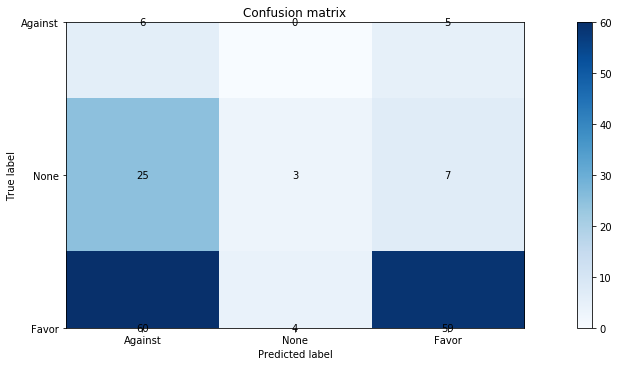

In [18]:
#show metrics
metrics(true_labels, test_probs)

In [19]:
#Feminism

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Feminist Movement'], 'elmo')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 531 samples, validate on 133 samples
Epoch 1/100
531/531 - 1s - loss: 745.8152 - categorical_accuracy: 0.3540 - val_loss: 1358.3867 - val_categorical_accuracy: 0.0602
Epoch 2/100
531/531 - 1s - loss: 651.0704 - categorical_accuracy: 0.3748 - val_loss: 1058.2176 - val_categorical_accuracy: 0.0752
Epoch 3/100
531/531 - 1s - loss: 494.9102 - categorical_accuracy: 0.4030 - val_loss: 769.7767 - val_categorical_accuracy: 0.0902
Epoch 4/100
531/531 - 1s - loss: 380.2195 - categorical_accuracy: 0.3992 - val_loss: 577.4740 - val_categorical_accuracy: 0.0902
Epoch 5/100
531/531 - 1s - loss: 332.9570 - categorical_accuracy: 0.3484 - val_loss: 450.3927 - val_categorical_accuracy: 0.1579
Epoch 6/100
531/531 - 1s - loss: 287.7039 - categorical_accuracy: 0.4068 - val_loss: 366.0652 - val_categorical_accuracy: 0.2782
Epoch 7/100
531/531 - 1s - loss: 261.3462 - categorical_accuracy: 0.4143 - val_loss: 297.6954 - val_categorical_accuracy: 0.4511
Epoch 8/100
531/531 - 1s - loss: 249.9791 - categ

Epoch 64/100
531/531 - 1s - loss: 155.4033 - categorical_accuracy: 0.6817 - val_loss: 234.1914 - val_categorical_accuracy: 0.5714
Epoch 65/100
531/531 - 1s - loss: 152.4096 - categorical_accuracy: 0.6836 - val_loss: 236.5298 - val_categorical_accuracy: 0.5564
Epoch 66/100
531/531 - 1s - loss: 148.2007 - categorical_accuracy: 0.6930 - val_loss: 236.9109 - val_categorical_accuracy: 0.5789
Epoch 67/100
531/531 - 1s - loss: 146.8841 - categorical_accuracy: 0.6911 - val_loss: 235.9791 - val_categorical_accuracy: 0.5564
Epoch 68/100
531/531 - 1s - loss: 156.1628 - categorical_accuracy: 0.6742 - val_loss: 231.4441 - val_categorical_accuracy: 0.5789
Epoch 69/100
531/531 - 1s - loss: 148.6633 - categorical_accuracy: 0.6874 - val_loss: 229.3442 - val_categorical_accuracy: 0.5714
Epoch 70/100
531/531 - 1s - loss: 145.7733 - categorical_accuracy: 0.6911 - val_loss: 227.0986 - val_categorical_accuracy: 0.5865
Epoch 71/100
531/531 - 1s - loss: 146.4548 - categorical_accuracy: 0.7081 - val_loss: 234.

F1 macro score: 0.31084527935913325
              precision    recall  f1-score   support

     Against       0.60      0.70      0.65       183
        None       0.50      0.14      0.21        44
       Favor       0.07      0.07      0.07        58

   micro avg       0.49      0.49      0.49       285
   macro avg       0.39      0.30      0.31       285
weighted avg       0.48      0.49      0.46       285



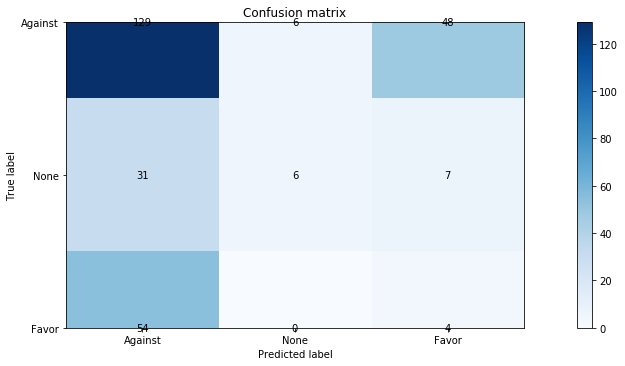

In [20]:
#show metrics
metrics(true_labels, test_probs)

In [21]:
#All

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton', 
                                                                              'Legalization of Abortion', 
                                                                              'Climate Change is a Real Concern',
                                                                              'Feminist Movement', 
                                                                              'Atheism'], 'elmo')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 2331 samples, validate on 583 samples
Epoch 1/100
2331/2331 - 3s - loss: 1005.2200 - categorical_accuracy: 0.5161 - val_loss: 899.8806 - val_categorical_accuracy: 0.5780
Epoch 2/100
2331/2331 - 3s - loss: 957.6266 - categorical_accuracy: 0.5238 - val_loss: 933.9051 - val_categorical_accuracy: 0.5609
Epoch 3/100
2331/2331 - 3s - loss: 888.1999 - categorical_accuracy: 0.5680 - val_loss: 852.7872 - val_categorical_accuracy: 0.6003
Epoch 4/100
2331/2331 - 3s - loss: 853.5901 - categorical_accuracy: 0.5611 - val_loss: 888.6582 - val_categorical_accuracy: 0.5866
Epoch 5/100
2331/2331 - 3s - loss: 818.9985 - categorical_accuracy: 0.5882 - val_loss: 851.2103 - val_categorical_accuracy: 0.6072
Epoch 6/100
2331/2331 - 3s - loss: 794.3124 - categorical_accuracy: 0.6006 - val_loss: 819.5735 - val_categorical_accuracy: 0.6278
Epoch 7/100
2331/2331 - 3s - loss: 787.6416 - categorical_accuracy: 0.5993 - val_loss: 864.2547 - val_categorical_accuracy: 0.5918
Epoch 8/100
2331/2331 - 3s - loss: 

Epoch 63/100
2331/2331 - 3s - loss: 533.1251 - categorical_accuracy: 0.7525 - val_loss: 1090.1796 - val_categorical_accuracy: 0.5660
Epoch 64/100
2331/2331 - 3s - loss: 540.6691 - categorical_accuracy: 0.7503 - val_loss: 1022.1411 - val_categorical_accuracy: 0.5969
Epoch 65/100
2331/2331 - 3s - loss: 542.5634 - categorical_accuracy: 0.7357 - val_loss: 1065.8973 - val_categorical_accuracy: 0.5712
Epoch 66/100
2331/2331 - 3s - loss: 545.8231 - categorical_accuracy: 0.7503 - val_loss: 1099.6415 - val_categorical_accuracy: 0.5592
Epoch 67/100
2331/2331 - 3s - loss: 552.9629 - categorical_accuracy: 0.7477 - val_loss: 1050.5311 - val_categorical_accuracy: 0.5729
Epoch 68/100
2331/2331 - 3s - loss: 551.7040 - categorical_accuracy: 0.7340 - val_loss: 1022.2480 - val_categorical_accuracy: 0.5849
Epoch 69/100
2331/2331 - 3s - loss: 548.2467 - categorical_accuracy: 0.7370 - val_loss: 1049.6084 - val_categorical_accuracy: 0.5678
Epoch 70/100
2331/2331 - 3s - loss: 537.9687 - categorical_accuracy: 

F1 macro score: 0.39708615117281476
              precision    recall  f1-score   support

     Against       0.60      0.61      0.61       715
        None       0.30      0.23      0.26       230
       Favor       0.30      0.34      0.32       304

   micro avg       0.48      0.48      0.48      1249
   macro avg       0.40      0.40      0.40      1249
weighted avg       0.47      0.48      0.47      1249



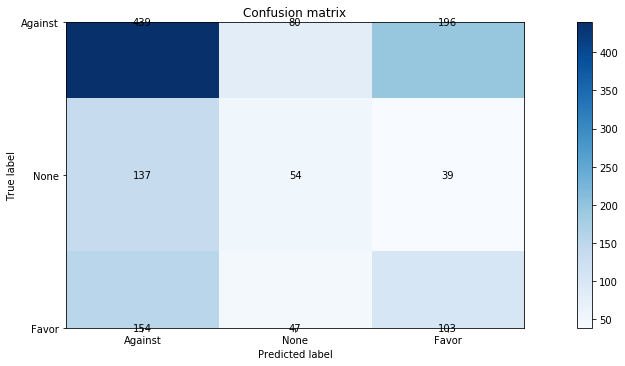

In [22]:
#show metrics
metrics(true_labels, test_probs)

# Run LSTM on 'LSTM1' outputs

In [23]:
#Atheism

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Atheism'], 'lstm_outputs1')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 410 samples, validate on 103 samples
Epoch 1/100
410/410 - 1s - loss: 179.8606 - categorical_accuracy: 0.6073 - val_loss: 182.3879 - val_categorical_accuracy: 0.6505
Epoch 2/100
410/410 - 1s - loss: 195.8520 - categorical_accuracy: 0.5902 - val_loss: 154.7662 - val_categorical_accuracy: 0.7282
Epoch 3/100
410/410 - 1s - loss: 166.5781 - categorical_accuracy: 0.6000 - val_loss: 125.9640 - val_categorical_accuracy: 0.8155
Epoch 4/100
410/410 - 1s - loss: 164.9706 - categorical_accuracy: 0.6073 - val_loss: 108.1049 - val_categorical_accuracy: 0.8155
Epoch 5/100
410/410 - 1s - loss: 140.5174 - categorical_accuracy: 0.6268 - val_loss: 94.0622 - val_categorical_accuracy: 0.8447
Epoch 6/100
410/410 - 1s - loss: 140.0329 - categorical_accuracy: 0.6268 - val_loss: 85.2221 - val_categorical_accuracy: 0.8641
Epoch 7/100
410/410 - 1s - loss: 136.3171 - categorical_accuracy: 0.6220 - val_loss: 80.1414 - val_categorical_accuracy: 0.8835
Epoch 8/100
410/410 - 1s - loss: 120.6789 - categorica

Epoch 65/100
410/410 - 1s - loss: 91.3003 - categorical_accuracy: 0.7195 - val_loss: 76.6405 - val_categorical_accuracy: 0.8932
Epoch 66/100
410/410 - 1s - loss: 89.8390 - categorical_accuracy: 0.6951 - val_loss: 75.1409 - val_categorical_accuracy: 0.8932
Epoch 67/100
410/410 - 1s - loss: 92.9687 - categorical_accuracy: 0.6976 - val_loss: 73.7679 - val_categorical_accuracy: 0.9029
Epoch 68/100
410/410 - 1s - loss: 96.2032 - categorical_accuracy: 0.7146 - val_loss: 74.6469 - val_categorical_accuracy: 0.8932
Epoch 69/100
410/410 - 1s - loss: 85.5958 - categorical_accuracy: 0.7463 - val_loss: 76.4994 - val_categorical_accuracy: 0.8835
Epoch 70/100
410/410 - 1s - loss: 96.1382 - categorical_accuracy: 0.6878 - val_loss: 77.8631 - val_categorical_accuracy: 0.8835
Epoch 71/100
410/410 - 1s - loss: 93.3443 - categorical_accuracy: 0.7146 - val_loss: 78.2247 - val_categorical_accuracy: 0.8835
Epoch 72/100
410/410 - 1s - loss: 78.7963 - categorical_accuracy: 0.7488 - val_loss: 77.6168 - val_categ

F1 macro score: 0.380840095190782
              precision    recall  f1-score   support

     Against       0.75      0.83      0.79       160
        None       0.27      0.14      0.19        28
       Favor       0.19      0.16      0.17        32

   micro avg       0.65      0.65      0.65       220
   macro avg       0.40      0.38      0.38       220
weighted avg       0.60      0.65      0.62       220



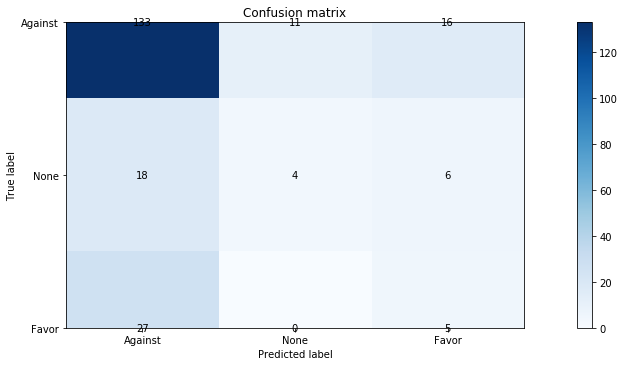

In [24]:
#show metrics
metrics(true_labels, test_probs)

In [25]:
#Hillary Clinton

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton'], 'lstm_outputs1')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 551 samples, validate on 138 samples
Epoch 1/100
551/551 - 1s - loss: 198.2068 - categorical_accuracy: 0.6316 - val_loss: 130.6511 - val_categorical_accuracy: 0.8478
Epoch 2/100
551/551 - 1s - loss: 191.4474 - categorical_accuracy: 0.6461 - val_loss: 119.6085 - val_categorical_accuracy: 0.8551
Epoch 3/100
551/551 - 1s - loss: 208.1242 - categorical_accuracy: 0.5971 - val_loss: 108.5803 - val_categorical_accuracy: 0.8551
Epoch 4/100
551/551 - 1s - loss: 177.8965 - categorical_accuracy: 0.6062 - val_loss: 102.7919 - val_categorical_accuracy: 0.8551
Epoch 5/100
551/551 - 1s - loss: 179.7324 - categorical_accuracy: 0.6370 - val_loss: 99.6888 - val_categorical_accuracy: 0.8623
Epoch 6/100
551/551 - 1s - loss: 175.3295 - categorical_accuracy: 0.6624 - val_loss: 96.6366 - val_categorical_accuracy: 0.8623
Epoch 7/100
551/551 - 1s - loss: 162.4212 - categorical_accuracy: 0.6606 - val_loss: 93.9216 - val_categorical_accuracy: 0.8696
Epoch 8/100
551/551 - 1s - loss: 167.9375 - categorica

Epoch 65/100
551/551 - 1s - loss: 117.6659 - categorical_accuracy: 0.7423 - val_loss: 84.3304 - val_categorical_accuracy: 0.8841
Epoch 66/100
551/551 - 1s - loss: 103.2499 - categorical_accuracy: 0.7695 - val_loss: 84.5570 - val_categorical_accuracy: 0.8841
Epoch 67/100
551/551 - 1s - loss: 121.7311 - categorical_accuracy: 0.7278 - val_loss: 85.3503 - val_categorical_accuracy: 0.8841
Epoch 68/100
551/551 - 1s - loss: 112.9503 - categorical_accuracy: 0.7423 - val_loss: 87.9969 - val_categorical_accuracy: 0.8768
Epoch 69/100
551/551 - 1s - loss: 107.4682 - categorical_accuracy: 0.7550 - val_loss: 88.9701 - val_categorical_accuracy: 0.8696
Epoch 70/100
551/551 - 1s - loss: 113.4819 - categorical_accuracy: 0.7532 - val_loss: 90.2296 - val_categorical_accuracy: 0.8768
Epoch 71/100
551/551 - 1s - loss: 105.6952 - categorical_accuracy: 0.7550 - val_loss: 89.9120 - val_categorical_accuracy: 0.8768
Epoch 72/100
551/551 - 1s - loss: 110.6370 - categorical_accuracy: 0.7514 - val_loss: 89.3931 - v

F1 macro score: 0.3679876468068799
              precision    recall  f1-score   support

     Against       0.60      0.65      0.62       172
        None       0.37      0.22      0.27        78
       Favor       0.18      0.24      0.21        45

   micro avg       0.47      0.47      0.47       295
   macro avg       0.38      0.37      0.37       295
weighted avg       0.47      0.47      0.47       295



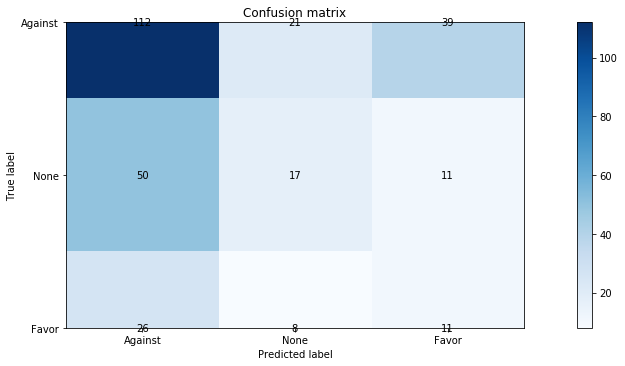

In [26]:
#show metrics
metrics(true_labels, test_probs)

In [27]:
#Abortion

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Legalization of Abortion'], 'lstm_outputs1')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 522 samples, validate on 131 samples
Epoch 1/100
522/522 - 1s - loss: 284.3542 - categorical_accuracy: 0.4885 - val_loss: 248.1333 - val_categorical_accuracy: 0.6336
Epoch 2/100
522/522 - 1s - loss: 282.5082 - categorical_accuracy: 0.5000 - val_loss: 227.5943 - val_categorical_accuracy: 0.6260
Epoch 3/100
522/522 - 1s - loss: 238.6917 - categorical_accuracy: 0.5268 - val_loss: 213.4512 - val_categorical_accuracy: 0.6565
Epoch 4/100
522/522 - 1s - loss: 251.1667 - categorical_accuracy: 0.5038 - val_loss: 202.5863 - val_categorical_accuracy: 0.6641
Epoch 5/100
522/522 - 1s - loss: 234.9740 - categorical_accuracy: 0.5326 - val_loss: 196.5139 - val_categorical_accuracy: 0.6641
Epoch 6/100
522/522 - 1s - loss: 237.2898 - categorical_accuracy: 0.5096 - val_loss: 194.3025 - val_categorical_accuracy: 0.6641
Epoch 7/100
522/522 - 1s - loss: 223.5608 - categorical_accuracy: 0.5594 - val_loss: 190.8805 - val_categorical_accuracy: 0.6641
Epoch 8/100
522/522 - 1s - loss: 217.8223 - categor

Epoch 64/100
522/522 - 1s - loss: 133.2042 - categorical_accuracy: 0.6877 - val_loss: 211.9205 - val_categorical_accuracy: 0.6031
Epoch 65/100
522/522 - 1s - loss: 136.6569 - categorical_accuracy: 0.6916 - val_loss: 211.7803 - val_categorical_accuracy: 0.6031
Epoch 66/100
522/522 - 1s - loss: 133.2896 - categorical_accuracy: 0.6782 - val_loss: 209.5846 - val_categorical_accuracy: 0.5954
Epoch 67/100
522/522 - 1s - loss: 135.3159 - categorical_accuracy: 0.6743 - val_loss: 211.5121 - val_categorical_accuracy: 0.5878
Epoch 68/100
522/522 - 1s - loss: 133.5201 - categorical_accuracy: 0.6705 - val_loss: 212.4701 - val_categorical_accuracy: 0.5954
Epoch 69/100
522/522 - 1s - loss: 134.5539 - categorical_accuracy: 0.6628 - val_loss: 212.7914 - val_categorical_accuracy: 0.5954
Epoch 70/100
522/522 - 1s - loss: 134.9268 - categorical_accuracy: 0.6877 - val_loss: 212.4768 - val_categorical_accuracy: 0.6031
Epoch 71/100
522/522 - 1s - loss: 124.9074 - categorical_accuracy: 0.7165 - val_loss: 211.

F1 macro score: 0.387638326585695
              precision    recall  f1-score   support

     Against       0.68      0.72      0.70       189
        None       0.26      0.29      0.27        45
       Favor       0.24      0.15      0.19        46

   micro avg       0.56      0.56      0.56       280
   macro avg       0.39      0.39      0.39       280
weighted avg       0.54      0.56      0.55       280



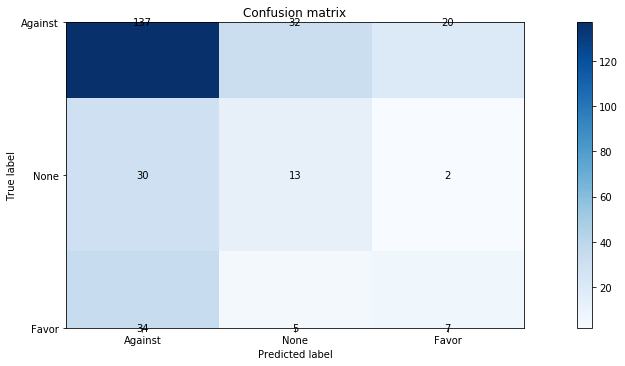

In [28]:
#show metrics
metrics(true_labels, test_probs)

In [29]:
#Climate

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Climate Change is a Real Concern'], 'lstm_outputs1')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 316 samples, validate on 79 samples
Epoch 1/100
316/316 - 1s - loss: 333.2243 - categorical_accuracy: 0.3165 - val_loss: 249.3172 - val_categorical_accuracy: 0.4557
Epoch 2/100
316/316 - 0s - loss: 298.7765 - categorical_accuracy: 0.3671 - val_loss: 204.3284 - val_categorical_accuracy: 0.5190
Epoch 3/100
316/316 - 0s - loss: 280.3495 - categorical_accuracy: 0.4051 - val_loss: 165.7508 - val_categorical_accuracy: 0.5949
Epoch 4/100
316/316 - 0s - loss: 219.9136 - categorical_accuracy: 0.4747 - val_loss: 138.3226 - val_categorical_accuracy: 0.7089
Epoch 5/100
316/316 - 0s - loss: 191.1661 - categorical_accuracy: 0.5032 - val_loss: 118.7233 - val_categorical_accuracy: 0.7722
Epoch 6/100
316/316 - 0s - loss: 162.8858 - categorical_accuracy: 0.6108 - val_loss: 106.9564 - val_categorical_accuracy: 0.7722
Epoch 7/100
316/316 - 0s - loss: 142.7018 - categorical_accuracy: 0.6582 - val_loss: 99.9461 - val_categorical_accuracy: 0.7722
Epoch 8/100
316/316 - 0s - loss: 137.3216 - categoric

Epoch 65/100
316/316 - 0s - loss: 52.0472 - categorical_accuracy: 0.8829 - val_loss: 69.9013 - val_categorical_accuracy: 0.7975
Epoch 66/100
316/316 - 1s - loss: 53.9602 - categorical_accuracy: 0.8861 - val_loss: 69.2133 - val_categorical_accuracy: 0.7975
Epoch 67/100
316/316 - 1s - loss: 57.4149 - categorical_accuracy: 0.8671 - val_loss: 69.0299 - val_categorical_accuracy: 0.7975
Epoch 68/100
316/316 - 1s - loss: 56.0606 - categorical_accuracy: 0.8576 - val_loss: 69.4247 - val_categorical_accuracy: 0.7975
Epoch 69/100
316/316 - 0s - loss: 57.4880 - categorical_accuracy: 0.8671 - val_loss: 70.0645 - val_categorical_accuracy: 0.7975
Epoch 70/100
316/316 - 0s - loss: 46.2185 - categorical_accuracy: 0.8987 - val_loss: 70.7964 - val_categorical_accuracy: 0.7975
Epoch 71/100
316/316 - 0s - loss: 57.6785 - categorical_accuracy: 0.8576 - val_loss: 71.5363 - val_categorical_accuracy: 0.7975
Epoch 72/100
316/316 - 0s - loss: 62.2468 - categorical_accuracy: 0.8386 - val_loss: 71.7050 - val_categ

F1 macro score: 0.4397673682280991
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.44      0.60      0.51        35
       Favor       0.83      0.80      0.81       123

   micro avg       0.70      0.70      0.70       169
   macro avg       0.42      0.47      0.44       169
weighted avg       0.70      0.70      0.70       169



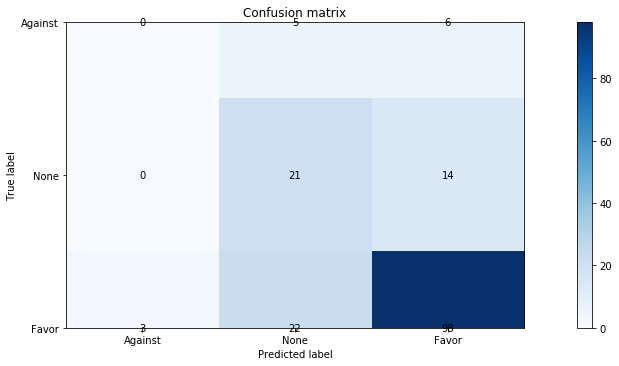

In [30]:
#show metrics
metrics(true_labels, test_probs)

In [31]:
#Feminism

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Feminist Movement'], 'lstm_outputs1')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 531 samples, validate on 133 samples
Epoch 1/100
531/531 - 1s - loss: 520.6455 - categorical_accuracy: 0.4614 - val_loss: 954.4972 - val_categorical_accuracy: 0.1729
Epoch 2/100
531/531 - 1s - loss: 428.9809 - categorical_accuracy: 0.4934 - val_loss: 625.3099 - val_categorical_accuracy: 0.2707
Epoch 3/100
531/531 - 1s - loss: 289.6762 - categorical_accuracy: 0.5461 - val_loss: 362.0151 - val_categorical_accuracy: 0.4511
Epoch 4/100
531/531 - 1s - loss: 212.5704 - categorical_accuracy: 0.6102 - val_loss: 231.5039 - val_categorical_accuracy: 0.6165
Epoch 5/100
531/531 - 1s - loss: 182.9921 - categorical_accuracy: 0.6008 - val_loss: 169.7473 - val_categorical_accuracy: 0.7444
Epoch 6/100
531/531 - 1s - loss: 183.3006 - categorical_accuracy: 0.6177 - val_loss: 146.3184 - val_categorical_accuracy: 0.7669
Epoch 7/100
531/531 - 1s - loss: 184.6027 - categorical_accuracy: 0.5895 - val_loss: 139.7656 - val_categorical_accuracy: 0.7895
Epoch 8/100
531/531 - 1s - loss: 172.9520 - categor

Epoch 64/100
531/531 - 1s - loss: 112.0222 - categorical_accuracy: 0.7627 - val_loss: 161.1014 - val_categorical_accuracy: 0.7594
Epoch 65/100
531/531 - 1s - loss: 114.2071 - categorical_accuracy: 0.7684 - val_loss: 161.8033 - val_categorical_accuracy: 0.7519
Epoch 66/100
531/531 - 1s - loss: 121.8440 - categorical_accuracy: 0.7514 - val_loss: 157.2985 - val_categorical_accuracy: 0.7820
Epoch 67/100
531/531 - 1s - loss: 105.4787 - categorical_accuracy: 0.7853 - val_loss: 153.8766 - val_categorical_accuracy: 0.7820
Epoch 68/100
531/531 - 1s - loss: 109.3335 - categorical_accuracy: 0.7608 - val_loss: 155.4668 - val_categorical_accuracy: 0.7744
Epoch 69/100
531/531 - 1s - loss: 107.8786 - categorical_accuracy: 0.7834 - val_loss: 155.6767 - val_categorical_accuracy: 0.7744
Epoch 70/100
531/531 - 1s - loss: 104.4196 - categorical_accuracy: 0.7815 - val_loss: 161.5404 - val_categorical_accuracy: 0.7594
Epoch 71/100
531/531 - 1s - loss: 100.5009 - categorical_accuracy: 0.8023 - val_loss: 165.

F1 macro score: 0.3676124840718606
              precision    recall  f1-score   support

     Against       0.61      0.39      0.48       183
        None       0.32      0.27      0.29        44
       Favor       0.24      0.53      0.33        58

   micro avg       0.40      0.40      0.40       285
   macro avg       0.39      0.40      0.37       285
weighted avg       0.49      0.40      0.42       285



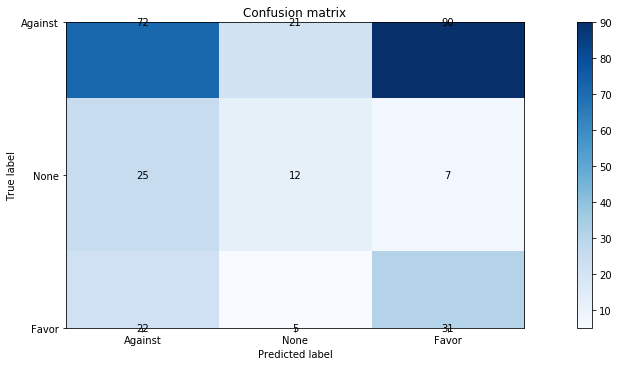

In [32]:
#show metrics
metrics(true_labels, test_probs)

In [33]:
#All

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton', 
                                                                              'Legalization of Abortion', 
                                                                              'Climate Change is a Real Concern',
                                                                              'Feminist Movement', 
                                                                              'Atheism'], 'lstm_outputs1')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 2331 samples, validate on 583 samples
Epoch 1/100
2331/2331 - 4s - loss: 712.0039 - categorical_accuracy: 0.6821 - val_loss: 746.9147 - val_categorical_accuracy: 0.6707
Epoch 2/100
2331/2331 - 4s - loss: 644.7949 - categorical_accuracy: 0.6950 - val_loss: 740.4861 - val_categorical_accuracy: 0.6758
Epoch 3/100
2331/2331 - 4s - loss: 630.2516 - categorical_accuracy: 0.7074 - val_loss: 738.8937 - val_categorical_accuracy: 0.6930
Epoch 4/100
2331/2331 - 3s - loss: 632.0385 - categorical_accuracy: 0.7036 - val_loss: 784.3165 - val_categorical_accuracy: 0.6672
Epoch 5/100
2331/2331 - 4s - loss: 602.9478 - categorical_accuracy: 0.7139 - val_loss: 762.5027 - val_categorical_accuracy: 0.6621
Epoch 6/100
2331/2331 - 4s - loss: 626.6688 - categorical_accuracy: 0.6847 - val_loss: 793.5165 - val_categorical_accuracy: 0.6604
Epoch 7/100
2331/2331 - 4s - loss: 609.4803 - categorical_accuracy: 0.7053 - val_loss: 799.0655 - val_categorical_accuracy: 0.6587
Epoch 8/100
2331/2331 - 4s - loss: 5

Epoch 63/100
2331/2331 - 4s - loss: 445.2935 - categorical_accuracy: 0.8035 - val_loss: 1066.3888 - val_categorical_accuracy: 0.5815
Epoch 64/100
2331/2331 - 5s - loss: 426.4069 - categorical_accuracy: 0.8018 - val_loss: 1109.5180 - val_categorical_accuracy: 0.5918
Epoch 65/100
2331/2331 - 5s - loss: 452.5134 - categorical_accuracy: 0.8014 - val_loss: 1162.6260 - val_categorical_accuracy: 0.5883
Epoch 66/100
2331/2331 - 6s - loss: 457.6793 - categorical_accuracy: 0.7988 - val_loss: 1110.3594 - val_categorical_accuracy: 0.5935
Epoch 67/100
2331/2331 - 5s - loss: 446.8992 - categorical_accuracy: 0.7979 - val_loss: 1087.3551 - val_categorical_accuracy: 0.5815
Epoch 68/100
2331/2331 - 5s - loss: 442.7649 - categorical_accuracy: 0.7984 - val_loss: 1102.5128 - val_categorical_accuracy: 0.5695
Epoch 69/100
2331/2331 - 5s - loss: 416.2086 - categorical_accuracy: 0.8177 - val_loss: 1124.6456 - val_categorical_accuracy: 0.5746
Epoch 70/100
2331/2331 - 5s - loss: 443.8770 - categorical_accuracy: 

F1 macro score: 0.43124293228251215
              precision    recall  f1-score   support

     Against       0.62      0.66      0.64       715
        None       0.29      0.30      0.30       230
       Favor       0.39      0.33      0.36       304

   micro avg       0.51      0.51      0.51      1249
   macro avg       0.44      0.43      0.43      1249
weighted avg       0.51      0.51      0.51      1249



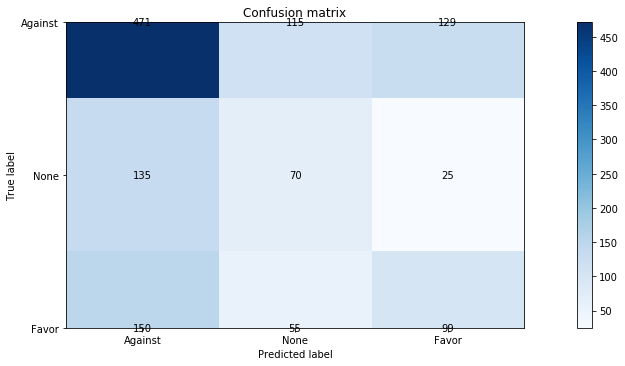

In [34]:
#show metrics
metrics(true_labels, test_probs)

# Run LSTM on 'LSTM2' outputs

In [35]:
#Atheism

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Atheism'], 'lstm_outputs2')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 410 samples, validate on 103 samples
Epoch 1/100
410/410 - 1s - loss: 162.5092 - categorical_accuracy: 0.6415 - val_loss: 121.4918 - val_categorical_accuracy: 0.7476
Epoch 2/100
410/410 - 1s - loss: 173.9297 - categorical_accuracy: 0.6024 - val_loss: 112.1340 - val_categorical_accuracy: 0.7767
Epoch 3/100
410/410 - 1s - loss: 153.8169 - categorical_accuracy: 0.5976 - val_loss: 103.9852 - val_categorical_accuracy: 0.7767
Epoch 4/100
410/410 - 1s - loss: 157.1708 - categorical_accuracy: 0.6122 - val_loss: 96.7547 - val_categorical_accuracy: 0.8058
Epoch 5/100
410/410 - 1s - loss: 126.7017 - categorical_accuracy: 0.6732 - val_loss: 94.6353 - val_categorical_accuracy: 0.7961
Epoch 6/100
410/410 - 1s - loss: 150.7640 - categorical_accuracy: 0.6268 - val_loss: 91.8659 - val_categorical_accuracy: 0.8350
Epoch 7/100
410/410 - 1s - loss: 152.6901 - categorical_accuracy: 0.5951 - val_loss: 87.7567 - val_categorical_accuracy: 0.8544
Epoch 8/100
410/410 - 1s - loss: 149.5866 - categorical

Epoch 65/100
410/410 - 1s - loss: 96.5735 - categorical_accuracy: 0.7366 - val_loss: 92.3295 - val_categorical_accuracy: 0.8350
Epoch 66/100
410/410 - 1s - loss: 99.1108 - categorical_accuracy: 0.7195 - val_loss: 89.5693 - val_categorical_accuracy: 0.8350
Epoch 67/100
410/410 - 1s - loss: 89.9223 - categorical_accuracy: 0.7341 - val_loss: 87.4630 - val_categorical_accuracy: 0.8350
Epoch 68/100
410/410 - 1s - loss: 99.9335 - categorical_accuracy: 0.6951 - val_loss: 85.9966 - val_categorical_accuracy: 0.8155
Epoch 69/100
410/410 - 1s - loss: 90.8456 - categorical_accuracy: 0.7317 - val_loss: 85.6716 - val_categorical_accuracy: 0.8252
Epoch 70/100
410/410 - 1s - loss: 109.0453 - categorical_accuracy: 0.7049 - val_loss: 86.5634 - val_categorical_accuracy: 0.8350
Epoch 71/100
410/410 - 1s - loss: 99.9770 - categorical_accuracy: 0.7366 - val_loss: 88.0098 - val_categorical_accuracy: 0.8350
Epoch 72/100
410/410 - 1s - loss: 95.2416 - categorical_accuracy: 0.7195 - val_loss: 90.7332 - val_cate

F1 macro score: 0.4016298439169195
              precision    recall  f1-score   support

     Against       0.77      0.78      0.77       160
        None       0.24      0.39      0.30        28
       Favor       0.23      0.09      0.13        32

   micro avg       0.63      0.63      0.63       220
   macro avg       0.41      0.42      0.40       220
weighted avg       0.62      0.63      0.62       220



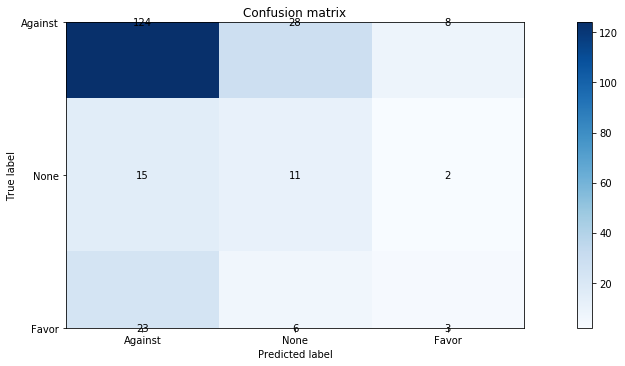

In [36]:
#show metrics
metrics(true_labels, test_probs)

In [37]:
#Hillary Clinton

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton'], 'lstm_outputs2')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 551 samples, validate on 138 samples
Epoch 1/100
551/551 - 1s - loss: 233.6846 - categorical_accuracy: 0.5935 - val_loss: 149.0254 - val_categorical_accuracy: 0.7971
Epoch 2/100
551/551 - 1s - loss: 211.5398 - categorical_accuracy: 0.6298 - val_loss: 137.9290 - val_categorical_accuracy: 0.8043
Epoch 3/100
551/551 - 1s - loss: 217.1379 - categorical_accuracy: 0.6007 - val_loss: 132.9655 - val_categorical_accuracy: 0.8188
Epoch 4/100
551/551 - 1s - loss: 194.7193 - categorical_accuracy: 0.6243 - val_loss: 123.0043 - val_categorical_accuracy: 0.8406
Epoch 5/100
551/551 - 2s - loss: 184.3741 - categorical_accuracy: 0.6171 - val_loss: 122.2068 - val_categorical_accuracy: 0.8406
Epoch 6/100
551/551 - 2s - loss: 190.5544 - categorical_accuracy: 0.6171 - val_loss: 121.9431 - val_categorical_accuracy: 0.8188
Epoch 7/100
551/551 - 2s - loss: 197.4619 - categorical_accuracy: 0.6044 - val_loss: 123.2746 - val_categorical_accuracy: 0.8261
Epoch 8/100
551/551 - 1s - loss: 191.5955 - categor

Epoch 64/100
551/551 - 1s - loss: 137.2013 - categorical_accuracy: 0.7078 - val_loss: 114.0443 - val_categorical_accuracy: 0.8333
Epoch 65/100
551/551 - 1s - loss: 132.4637 - categorical_accuracy: 0.7114 - val_loss: 114.5179 - val_categorical_accuracy: 0.8261
Epoch 66/100
551/551 - 1s - loss: 129.4745 - categorical_accuracy: 0.7423 - val_loss: 113.9841 - val_categorical_accuracy: 0.8043
Epoch 67/100
551/551 - 1s - loss: 123.6113 - categorical_accuracy: 0.7114 - val_loss: 117.4619 - val_categorical_accuracy: 0.7971
Epoch 68/100
551/551 - 2s - loss: 130.5872 - categorical_accuracy: 0.7005 - val_loss: 120.1571 - val_categorical_accuracy: 0.8116
Epoch 69/100
551/551 - 1s - loss: 128.1710 - categorical_accuracy: 0.7405 - val_loss: 120.2435 - val_categorical_accuracy: 0.8116
Epoch 70/100
551/551 - 1s - loss: 136.9291 - categorical_accuracy: 0.7042 - val_loss: 116.9196 - val_categorical_accuracy: 0.8116
Epoch 71/100
551/551 - 1s - loss: 130.2962 - categorical_accuracy: 0.7205 - val_loss: 112.

F1 macro score: 0.44123344128681924
              precision    recall  f1-score   support

     Against       0.66      0.74      0.70       172
        None       0.44      0.45      0.45        78
       Favor       0.26      0.13      0.18        45

   micro avg       0.57      0.57      0.57       295
   macro avg       0.46      0.44      0.44       295
weighted avg       0.54      0.57      0.55       295



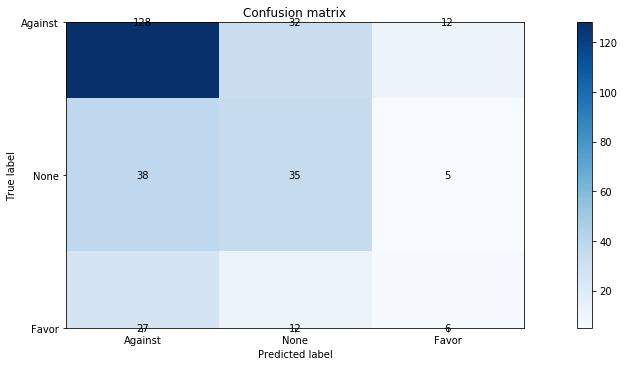

In [38]:
#show metrics
metrics(true_labels, test_probs)

In [39]:
#Abortion

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Legalization of Abortion'], 'lstm_outputs2')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 522 samples, validate on 131 samples
Epoch 1/100
522/522 - 1s - loss: 253.6716 - categorical_accuracy: 0.5326 - val_loss: 252.3423 - val_categorical_accuracy: 0.6031
Epoch 2/100
522/522 - 1s - loss: 244.8528 - categorical_accuracy: 0.5287 - val_loss: 252.6965 - val_categorical_accuracy: 0.5725
Epoch 3/100
522/522 - 1s - loss: 232.9045 - categorical_accuracy: 0.5651 - val_loss: 249.8062 - val_categorical_accuracy: 0.5649
Epoch 4/100
522/522 - 1s - loss: 232.6968 - categorical_accuracy: 0.5498 - val_loss: 242.1260 - val_categorical_accuracy: 0.5802
Epoch 5/100
522/522 - 1s - loss: 241.0230 - categorical_accuracy: 0.5383 - val_loss: 232.7191 - val_categorical_accuracy: 0.5878
Epoch 6/100
522/522 - 1s - loss: 221.2607 - categorical_accuracy: 0.5670 - val_loss: 224.2553 - val_categorical_accuracy: 0.6031
Epoch 7/100
522/522 - 1s - loss: 223.3098 - categorical_accuracy: 0.5536 - val_loss: 218.6660 - val_categorical_accuracy: 0.6260
Epoch 8/100
522/522 - 1s - loss: 214.7739 - categor

Epoch 64/100
522/522 - 1s - loss: 159.2990 - categorical_accuracy: 0.6398 - val_loss: 183.8342 - val_categorical_accuracy: 0.6565
Epoch 65/100
522/522 - 1s - loss: 152.0750 - categorical_accuracy: 0.6398 - val_loss: 184.4031 - val_categorical_accuracy: 0.6565
Epoch 66/100
522/522 - 1s - loss: 148.4702 - categorical_accuracy: 0.6533 - val_loss: 184.1585 - val_categorical_accuracy: 0.6641
Epoch 67/100
522/522 - 1s - loss: 146.5943 - categorical_accuracy: 0.6494 - val_loss: 185.3826 - val_categorical_accuracy: 0.6565
Epoch 68/100
522/522 - 1s - loss: 151.3358 - categorical_accuracy: 0.6571 - val_loss: 187.3032 - val_categorical_accuracy: 0.6565
Epoch 69/100
522/522 - 1s - loss: 160.5781 - categorical_accuracy: 0.6360 - val_loss: 188.7406 - val_categorical_accuracy: 0.6336
Epoch 70/100
522/522 - 1s - loss: 154.1831 - categorical_accuracy: 0.6590 - val_loss: 190.4588 - val_categorical_accuracy: 0.6260
Epoch 71/100
522/522 - 1s - loss: 156.6182 - categorical_accuracy: 0.6456 - val_loss: 191.

F1 macro score: 0.39748544266191327
              precision    recall  f1-score   support

     Against       0.69      0.68      0.69       189
        None       0.28      0.47      0.35        45
       Favor       0.25      0.11      0.15        46

   micro avg       0.55      0.55      0.55       280
   macro avg       0.41      0.42      0.40       280
weighted avg       0.55      0.55      0.55       280



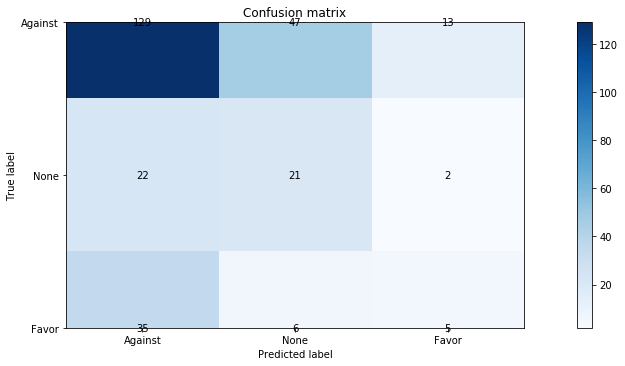

In [40]:
#show metrics
metrics(true_labels, test_probs)

In [41]:
#Climate

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Climate Change is a Real Concern'], 'lstm_outputs2')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 316 samples, validate on 79 samples
Epoch 1/100
316/316 - 1s - loss: 339.0218 - categorical_accuracy: 0.3544 - val_loss: 305.9448 - val_categorical_accuracy: 0.3924
Epoch 2/100
316/316 - 1s - loss: 315.6672 - categorical_accuracy: 0.3797 - val_loss: 268.3485 - val_categorical_accuracy: 0.4430
Epoch 3/100
316/316 - 1s - loss: 269.8400 - categorical_accuracy: 0.4209 - val_loss: 216.8146 - val_categorical_accuracy: 0.4684
Epoch 4/100
316/316 - 1s - loss: 233.4137 - categorical_accuracy: 0.4652 - val_loss: 178.8538 - val_categorical_accuracy: 0.5190
Epoch 5/100
316/316 - 1s - loss: 201.8256 - categorical_accuracy: 0.4968 - val_loss: 165.0033 - val_categorical_accuracy: 0.5949
Epoch 6/100
316/316 - 1s - loss: 187.9014 - categorical_accuracy: 0.5411 - val_loss: 157.7692 - val_categorical_accuracy: 0.6076
Epoch 7/100
316/316 - 1s - loss: 183.3309 - categorical_accuracy: 0.5411 - val_loss: 148.2590 - val_categorical_accuracy: 0.6076
Epoch 8/100
316/316 - 1s - loss: 155.0855 - categori

Epoch 65/100
316/316 - 1s - loss: 63.2754 - categorical_accuracy: 0.8544 - val_loss: 79.0142 - val_categorical_accuracy: 0.7595
Epoch 66/100
316/316 - 1s - loss: 70.4779 - categorical_accuracy: 0.8165 - val_loss: 82.1298 - val_categorical_accuracy: 0.7722
Epoch 67/100
316/316 - 1s - loss: 69.6987 - categorical_accuracy: 0.8196 - val_loss: 84.1821 - val_categorical_accuracy: 0.7848
Epoch 68/100
316/316 - 1s - loss: 63.6739 - categorical_accuracy: 0.8323 - val_loss: 88.1235 - val_categorical_accuracy: 0.7468
Epoch 69/100
316/316 - 1s - loss: 70.7178 - categorical_accuracy: 0.8196 - val_loss: 89.7132 - val_categorical_accuracy: 0.7468
Epoch 70/100
316/316 - 1s - loss: 56.8301 - categorical_accuracy: 0.8608 - val_loss: 89.8357 - val_categorical_accuracy: 0.7342
Epoch 71/100
316/316 - 1s - loss: 62.3264 - categorical_accuracy: 0.8513 - val_loss: 89.8491 - val_categorical_accuracy: 0.7342
Epoch 72/100
316/316 - 1s - loss: 71.8302 - categorical_accuracy: 0.8196 - val_loss: 89.3680 - val_categ

F1 macro score: 0.445507872800247
              precision    recall  f1-score   support

     Against       0.00      0.00      0.00        11
        None       0.48      0.60      0.53        35
       Favor       0.80      0.80      0.80       123

   micro avg       0.71      0.71      0.71       169
   macro avg       0.43      0.47      0.45       169
weighted avg       0.68      0.71      0.70       169



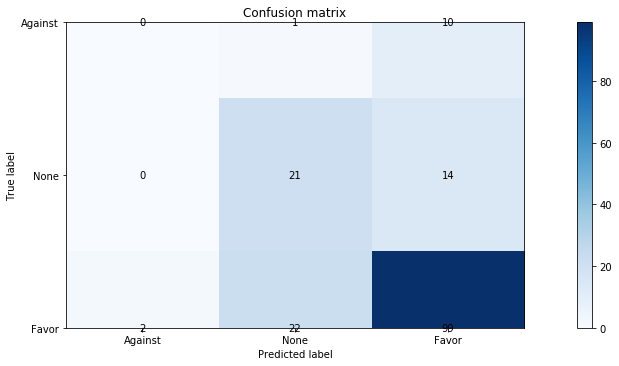

In [42]:
#show metrics
metrics(true_labels, test_probs)

In [43]:
#Feminism

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Feminist Movement'], 'lstm_outputs2')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 531 samples, validate on 133 samples
Epoch 1/100
531/531 - 1s - loss: 505.2869 - categorical_accuracy: 0.4708 - val_loss: 916.7678 - val_categorical_accuracy: 0.1955
Epoch 2/100
531/531 - 1s - loss: 415.6132 - categorical_accuracy: 0.5028 - val_loss: 665.6813 - val_categorical_accuracy: 0.2406
Epoch 3/100
531/531 - 1s - loss: 323.1303 - categorical_accuracy: 0.5235 - val_loss: 428.7744 - val_categorical_accuracy: 0.3609
Epoch 4/100
531/531 - 1s - loss: 248.5073 - categorical_accuracy: 0.5518 - val_loss: 304.0171 - val_categorical_accuracy: 0.4662
Epoch 5/100
531/531 - 1s - loss: 217.1588 - categorical_accuracy: 0.5480 - val_loss: 241.6232 - val_categorical_accuracy: 0.5789
Epoch 6/100
531/531 - 1s - loss: 196.9542 - categorical_accuracy: 0.5819 - val_loss: 205.1657 - val_categorical_accuracy: 0.6541
Epoch 7/100
531/531 - 1s - loss: 192.7507 - categorical_accuracy: 0.5819 - val_loss: 173.8170 - val_categorical_accuracy: 0.6842
Epoch 8/100
531/531 - 1s - loss: 196.3244 - categor

Epoch 64/100
531/531 - 1s - loss: 149.2482 - categorical_accuracy: 0.6911 - val_loss: 166.4303 - val_categorical_accuracy: 0.7143
Epoch 65/100
531/531 - 1s - loss: 138.4267 - categorical_accuracy: 0.7156 - val_loss: 169.6667 - val_categorical_accuracy: 0.6842
Epoch 66/100
531/531 - 1s - loss: 150.1567 - categorical_accuracy: 0.6648 - val_loss: 171.6445 - val_categorical_accuracy: 0.6992
Epoch 67/100
531/531 - 1s - loss: 141.8859 - categorical_accuracy: 0.6893 - val_loss: 169.1135 - val_categorical_accuracy: 0.7293
Epoch 68/100
531/531 - 1s - loss: 154.0149 - categorical_accuracy: 0.6554 - val_loss: 171.9071 - val_categorical_accuracy: 0.7068
Epoch 69/100
531/531 - 1s - loss: 154.2450 - categorical_accuracy: 0.7062 - val_loss: 177.3234 - val_categorical_accuracy: 0.7068
Epoch 70/100
531/531 - 1s - loss: 144.2215 - categorical_accuracy: 0.6987 - val_loss: 184.6197 - val_categorical_accuracy: 0.6767
Epoch 71/100
531/531 - 1s - loss: 133.6849 - categorical_accuracy: 0.7476 - val_loss: 185.

F1 macro score: 0.3762111561474619
              precision    recall  f1-score   support

     Against       0.60      0.43      0.50       183
        None       0.36      0.30      0.33        44
       Favor       0.23      0.47      0.31        58

   micro avg       0.41      0.41      0.41       285
   macro avg       0.40      0.40      0.38       285
weighted avg       0.48      0.41      0.43       285



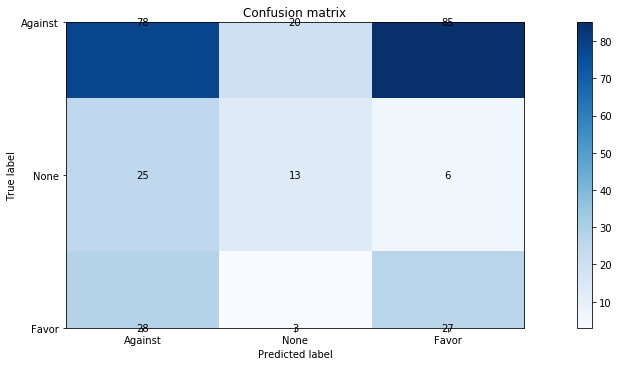

In [44]:
#show metrics
metrics(true_labels, test_probs)

In [45]:
#All

#obtain subset data
train_data, train_labels, test_data, test_labels, true_labels = topic_subset(['Hillary Clinton', 
                                                                              'Legalization of Abortion', 
                                                                              'Climate Change is a Real Concern',
                                                                              'Feminist Movement', 
                                                                              'Atheism'], 'lstm_outputs2')
weights = {0: train_labels[:,0].sum(), 1:train_labels[:,1].sum(), 2:train_labels[:,2].sum()}


#train model
lstm_mod.fit(
        train_data,
        train_labels,
        epochs=100,
        batch_size = 100,
        verbose=2,
        validation_split = 0.2,
        shuffle = True,
        class_weight = weights)

#make predictions
test_probs = lstm_mod.predict(test_data)

Train on 2331 samples, validate on 583 samples
Epoch 1/100
2331/2331 - 6s - loss: 725.5248 - categorical_accuracy: 0.6692 - val_loss: 785.0978 - val_categorical_accuracy: 0.6569
Epoch 2/100
2331/2331 - 6s - loss: 733.6960 - categorical_accuracy: 0.6598 - val_loss: 822.8402 - val_categorical_accuracy: 0.6432
Epoch 3/100
2331/2331 - 6s - loss: 696.8660 - categorical_accuracy: 0.6624 - val_loss: 802.3899 - val_categorical_accuracy: 0.6518
Epoch 4/100
2331/2331 - 5s - loss: 703.1776 - categorical_accuracy: 0.6572 - val_loss: 826.2265 - val_categorical_accuracy: 0.6329
Epoch 5/100
2331/2331 - 4s - loss: 677.5438 - categorical_accuracy: 0.6607 - val_loss: 853.8566 - val_categorical_accuracy: 0.6038
Epoch 6/100
2331/2331 - 4s - loss: 669.4021 - categorical_accuracy: 0.6791 - val_loss: 848.9337 - val_categorical_accuracy: 0.6398
Epoch 7/100
2331/2331 - 5s - loss: 664.8988 - categorical_accuracy: 0.6851 - val_loss: 869.8896 - val_categorical_accuracy: 0.6226
Epoch 8/100
2331/2331 - 5s - loss: 6

Epoch 63/100
2331/2331 - 4s - loss: 576.1593 - categorical_accuracy: 0.7284 - val_loss: 932.1697 - val_categorical_accuracy: 0.6003
Epoch 64/100
2331/2331 - 4s - loss: 595.5890 - categorical_accuracy: 0.7293 - val_loss: 962.6517 - val_categorical_accuracy: 0.6021
Epoch 65/100
2331/2331 - 3s - loss: 560.2634 - categorical_accuracy: 0.7293 - val_loss: 1016.1328 - val_categorical_accuracy: 0.5832
Epoch 66/100
2331/2331 - 4s - loss: 575.9292 - categorical_accuracy: 0.7289 - val_loss: 994.7136 - val_categorical_accuracy: 0.5849
Epoch 67/100
2331/2331 - 4s - loss: 577.2726 - categorical_accuracy: 0.7349 - val_loss: 972.6639 - val_categorical_accuracy: 0.5986
Epoch 68/100
2331/2331 - 4s - loss: 571.0843 - categorical_accuracy: 0.7306 - val_loss: 979.2308 - val_categorical_accuracy: 0.6141
Epoch 69/100
2331/2331 - 3s - loss: 564.3025 - categorical_accuracy: 0.7375 - val_loss: 973.4130 - val_categorical_accuracy: 0.6158
Epoch 70/100
2331/2331 - 3s - loss: 562.8505 - categorical_accuracy: 0.7349

F1 macro score: 0.4196968317723521
              precision    recall  f1-score   support

     Against       0.60      0.63      0.61       715
        None       0.34      0.30      0.31       230
       Favor       0.34      0.32      0.33       304

   micro avg       0.50      0.50      0.50      1249
   macro avg       0.42      0.42      0.42      1249
weighted avg       0.49      0.50      0.49      1249



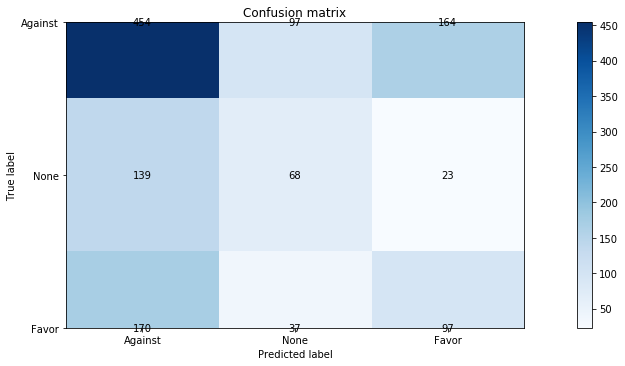

In [46]:
#show metrics
metrics(true_labels, test_probs)